In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dc=pd.read_csv('doctor_information.csv')
pt=pd.read_csv('patient_information.csv')
apt=pd.read_csv('appointments.csv')

In [3]:
dc.describe()

,ID,Age,Type,Experience,Hospital Location,Patients in Queue,Patients Seen in Lifetime
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,7760.760210,54.933190,50.453050,14.971910,950.023910,15.537560,5505.415220
std,4184.189546,14.751454,28.879966,8.943474,29.193538,8.674896,2597.791948
min,500.000000,30.000000,1.000000,0.000000,900.000000,1.000000,1000.000000
25%,4132.000000,42.000000,25.000000,7.000000,925.000000,8.000000,3258.000000
50%,7771.000000,55.000000,50.000000,15.000000,950.000000,16.000000,5504.000000
75%,11391.250000,68.000000,76.000000,23.000000,975.000000,23.000000,7753.000000
max,15000.000000,80.000000,100.000000,30.000000,1000.000000,30.000000,10000.000000


In [4]:
pt.describe()

,ID,Age,Gender,Health Condition,Hospital Location,Preferred Doctor Type,Last Appointment
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2997.029940,53.861420,1.501420,50.704980,950.039840,50.557780,183.981020
std,1158.672088,21.060809,0.500003,28.845212,29.068846,28.957266,105.450938
min,1000.000000,18.000000,1.000000,1.000000,900.000000,1.000000,1.000000
25%,1991.000000,36.000000,1.000000,26.000000,925.000000,26.000000,92.000000
50%,2992.000000,54.000000,2.000000,51.000000,950.000000,51.000000,185.000000
75%,4000.250000,72.000000,2.000000,76.000000,975.000000,76.000000,276.000000
max,5000.000000,90.000000,2.000000,100.000000,1000.000000,100.000000,365.000000


In [5]:
apt.describe()

,AppointmentID,PatientID,DoctorID,AppointmentDate,Rating
count,5462.000000,5462.000000,5462.000000,5462.000000,5462.000000
mean,9889.457525,3023.934456,7672.463383,182.081655,5.262175
std,5746.518934,1145.431241,4185.437865,105.603505,3.226270
min,2.000000,1000.000000,501.000000,1.000000,1.000000
25%,4937.750000,2050.500000,4048.000000,92.000000,2.000000
50%,9953.000000,3025.000000,7685.500000,180.000000,5.000000
75%,14833.750000,3992.750000,11313.500000,274.000000,9.000000
max,19997.000000,5000.000000,14996.000000,365.000000,10.000000


<Axes: xlabel='Rating'>

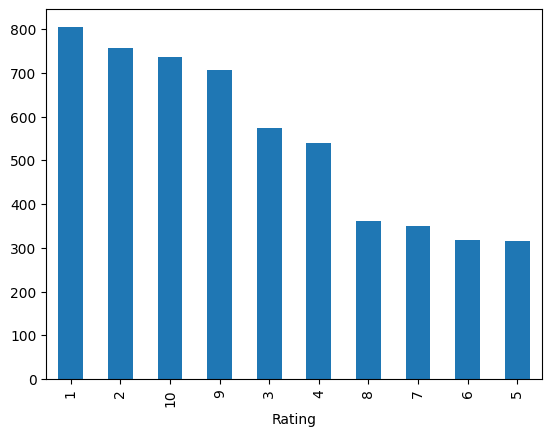

In [6]:
apt['Rating'].value_counts().plot(kind='bar')

In [7]:
# find if every appointment has a doctor and a patient whose information is available

apt['DoctorID'].isin(dc['ID']).value_counts()
apt['PatientID'].isin(pt['ID']).value_counts()

PatientID
True    5462
Name: count, dtype: int64

In [8]:
docs=np.array(dc['ID'])
pts=np.array(pt['ID'])

In [9]:
docs[0]
pts[0]

2335

In [10]:
# use this to create x values for the model which will be a list of lists of the form [[doctor information],[patient information]]

doctor_info = []
patient_info = []

for i in range(len(apt)):
    inf_doc = dc[dc['ID'] == apt['DoctorID'][i]]
    inf_pt = pt[pt['ID'] == apt['PatientID'][i]]
    inf_doc = inf_doc.values[0]                         #there is a problem here
    inf_pt = inf_pt.values[0]                            #there is a problem here
    doctor_info.append(inf_doc)
    patient_info.append(inf_pt)

doctor_info = np.array(doctor_info)
patient_info = np.array(patient_info)

y = apt['Rating'].values.tolist()

In [11]:
# normalize the data

doctor_info = (doctor_info - np.mean(doctor_info))/np.std(doctor_info)
patient_info = (patient_info - np.mean(patient_info))/np.std(patient_info)

In [12]:
doctor_info[0]
patient_info[0]

array([ 2.5435805 , -0.47582006, -0.54822132, -0.51514914,  0.30271691,
       -0.46509395, -0.40699418])

In [13]:
# create training and testing data

train_size = int(0.8*len(doctor_info))
test_size = len(doctor_info) - train_size

train_doctor_info = doctor_info[:train_size]
train_patient_info = patient_info[:train_size]
train_y = y[:train_size]

test_doctor_info = doctor_info[train_size:]
test_patient_info = patient_info[train_size:]
test_y = y[train_size:]

In [14]:
patient_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
])

doctor_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
])

In [15]:
@tf.function
def dot_product(x1,x2):
    y_net=[]
    print(x1)
    for i in range(len(x1)):
        y_net.append(tf.tensordot(x1[i],x2[i],axes=1))
    print(y_net)
    return y_net

In [16]:
# custom training loop

steps=len(train_doctor_info)//32

loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)


# x values batched into 32

batch_size=32
epochs=10

for epoch in range(epochs):
    print('Start of epoch %d' %(epoch,))
    for step in range(steps):
        x1=train_patient_info[step*batch_size:(step+1)*batch_size]
        x2=train_doctor_info[step*batch_size:(step+1)*batch_size]
        y_batch=train_y[step*batch_size:(step+1)*batch_size]
        with tf.GradientTape() as tape:
            patient_output=patient_model(x1)
            doctor_output=doctor_model(x2)
            # transpose doctor_output to get a column vector
            y_pred=dot_product(patient_output,doctor_output)
            loss_value=loss_fn(y_batch,y_pred)
        grads=tape.gradient(loss_value,patient_model.trainable_weights+doctor_model.trainable_weights)
        optimizer.apply_gradients(zip(grads,patient_model.trainable_weights+doctor_model.trainable_weights))
        if step%10==0:
            print('Training loss (for one batch) at step %s: %s' %(step,float(loss_value)))
            print('Seen so far: %s samples' %((step+1)*batch_size))
        if loss_value<0.01:
            break
    

Start of epoch 0
Tensor("x1:0", shape=(32, 16), dtype=float32)
[<tf.Tensor 'Tensordot:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_1:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_2:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_3:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_4:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_5:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_6:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_7:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_8:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_9:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_10:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_11:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_12:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_13:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_14:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_15:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_16:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_17:0' shape=() dtype=floa

In [17]:
def dot_product2(x1,x2):
    y_pred=[]
    for i in range(len(x1)):
        y_pred.append(tf.tensordot(x1[i],x2[i],axes=1))
    return y_pred

In [18]:
# test the model

patient_output=patient_model(test_patient_info)
doctor_output=doctor_model(test_doctor_info)

y_pred=dot_product2(patient_output,doctor_output)

In [19]:
y_pred=np.array(y_pred)

In [20]:
y_pred

array([4.8036733, 4.9379654, 5.0876255, ..., 4.936462 , 4.912013 ,
       5.110426 ], dtype=float32)

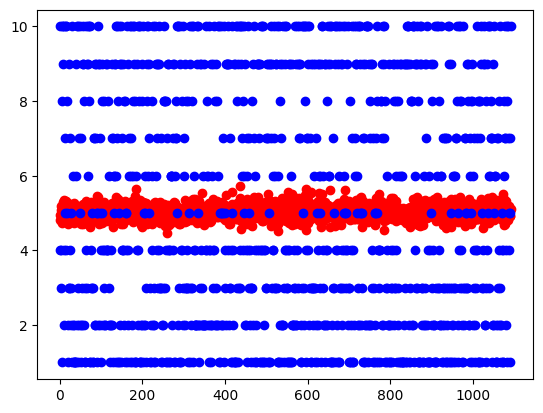

In [21]:
plt.scatter(range(len(test_y)),y_pred,color='red')
plt.scatter(range(len(test_y)),test_y,color='blue')